In [7]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer
pd.options.plotting.backend = 'plotly'

In [8]:
train = pd.read_csv('train.csv')
states = train['Province_State'].unique()
state_dfs_raw = {state: train[train['Province_State'] == state] for state in states}
state_means = {}
state_stds = {}
state_dfs = {}
for s, state_df_raw in state_dfs_raw.items():
    state_df = state_df_raw[['Confirmed', 'Deaths', 'Date']]
    state_df['Date'] = pd.to_datetime(state_df['Date'], format='%m-%d-%Y')
    state_df = state_df.set_index('Date')

    mean, std = state_df.mean(), state_df.std()
    state_df = (state_df - mean) / std

    state_means[s] = mean
    state_stds[s] = std
    state_dfs[s] = state_df

column_names = state_dfs['Alabama'].columns

In [9]:
from CustomModels import AR

lag_order = 15
n_features = column_names.size

def model_factory():
    model = AR(lag_order)
    return model

In [10]:
# Normally takes 80s to train
models = {}
model_histories = {}
model_test_data = {}
for state in states:
    stime = timer()
    print(f'------------------------\nTraining model for {state}')
    state_data = np.nan_to_num(state_dfs[state].values)
    state_data = np.diff(state_data, 1, axis=0)

    model = model_factory()
    res = model.fit(state_data)
    models[state] = model

    print(f'\tTraining took {timer() - stime:.4f}s')

------------------------
Training model for Alabama
	Training took 0.0042s
------------------------
Training model for Alaska
	Training took 0.0032s
------------------------
Training model for Arizona
	Training took 0.0017s
------------------------
Training model for Arkansas
	Training took 0.0021s
------------------------
Training model for California
	Training took 0.0016s
------------------------
Training model for Colorado
	Training took 0.0023s
------------------------
Training model for Connecticut
	Training took 0.0034s
------------------------
Training model for Delaware
	Training took 0.0013s
------------------------
Training model for Florida
	Training took 0.0012s
------------------------
Training model for Georgia
	Training took 0.0013s
------------------------
Training model for Hawaii
	Training took 0.0021s
------------------------
Training model for Idaho
	Training took 0.0015s
------------------------
Training model for Illinois
	Training took 0.0012s
------------------

In [11]:
def forecast(model, data, steps, columns, index):
    output = []
    for _ in range(steps):
        prediction = model.predict(data)
        output.append(prediction)
        data = np.vstack((data[1:], prediction))

    return pd.DataFrame(output, columns=columns, index=index)

In [12]:
state_forecasts = {}
periods = 26
columns, index = column_names, pd.date_range(state_dfs['Alabama'].index[-1], periods=periods + 1)[1:]
for state in states:
    print(f'Forecasting {state} ({index[0]} to {index[-1]})')
    data_df = state_dfs[state].iloc[-lag_order - 1:]

    forecast_df = forecast(models[state], np.diff(np.nan_to_num(data_df.values), axis=0), periods, columns, index)
    state_forecasts[state] = forecast_df.cumsum() + data_df.iloc[-1]

Forecasting Alabama (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Alaska (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Arizona (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Arkansas (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting California (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Colorado (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Connecticut (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Delaware (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Florida (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Georgia (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Hawaii (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Idaho (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Illinois (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Indiana (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Iowa (2020-09-01 00:00:00 to 2020-09-26 00:00:00)
Forecasting Kansas (2

In [45]:
cleaned_dfs = {}
for state in states:
    cleaned_df = state_forecasts[state][['Confirmed', 'Deaths']]
    cleaned_df['Province_State'] = state
    cleaned_df['Date'] = cleaned_df.index

    cleaned_df['Confirmed'] *= state_stds[state]['Confirmed']
    cleaned_df['Deaths'] *= state_stds[state]['Deaths']
    cleaned_df['Confirmed'] += state_means[state]['Confirmed']
    cleaned_df['Deaths'] += state_means[state]['Deaths']


    cleaned_dfs[state] = cleaned_df[['Province_State', 'Date', 'Confirmed', 'Deaths']]

kaggle_res = []

for _ in range(periods):
    for state in states:
        kaggle_res.append(cleaned_dfs[state].iloc[_])

kaggle_res = pd.DataFrame(kaggle_res).reset_index(drop=True)[['Confirmed', 'Deaths']].astype('int')
kaggle_res.index.rename('ForecastID', inplace=True)

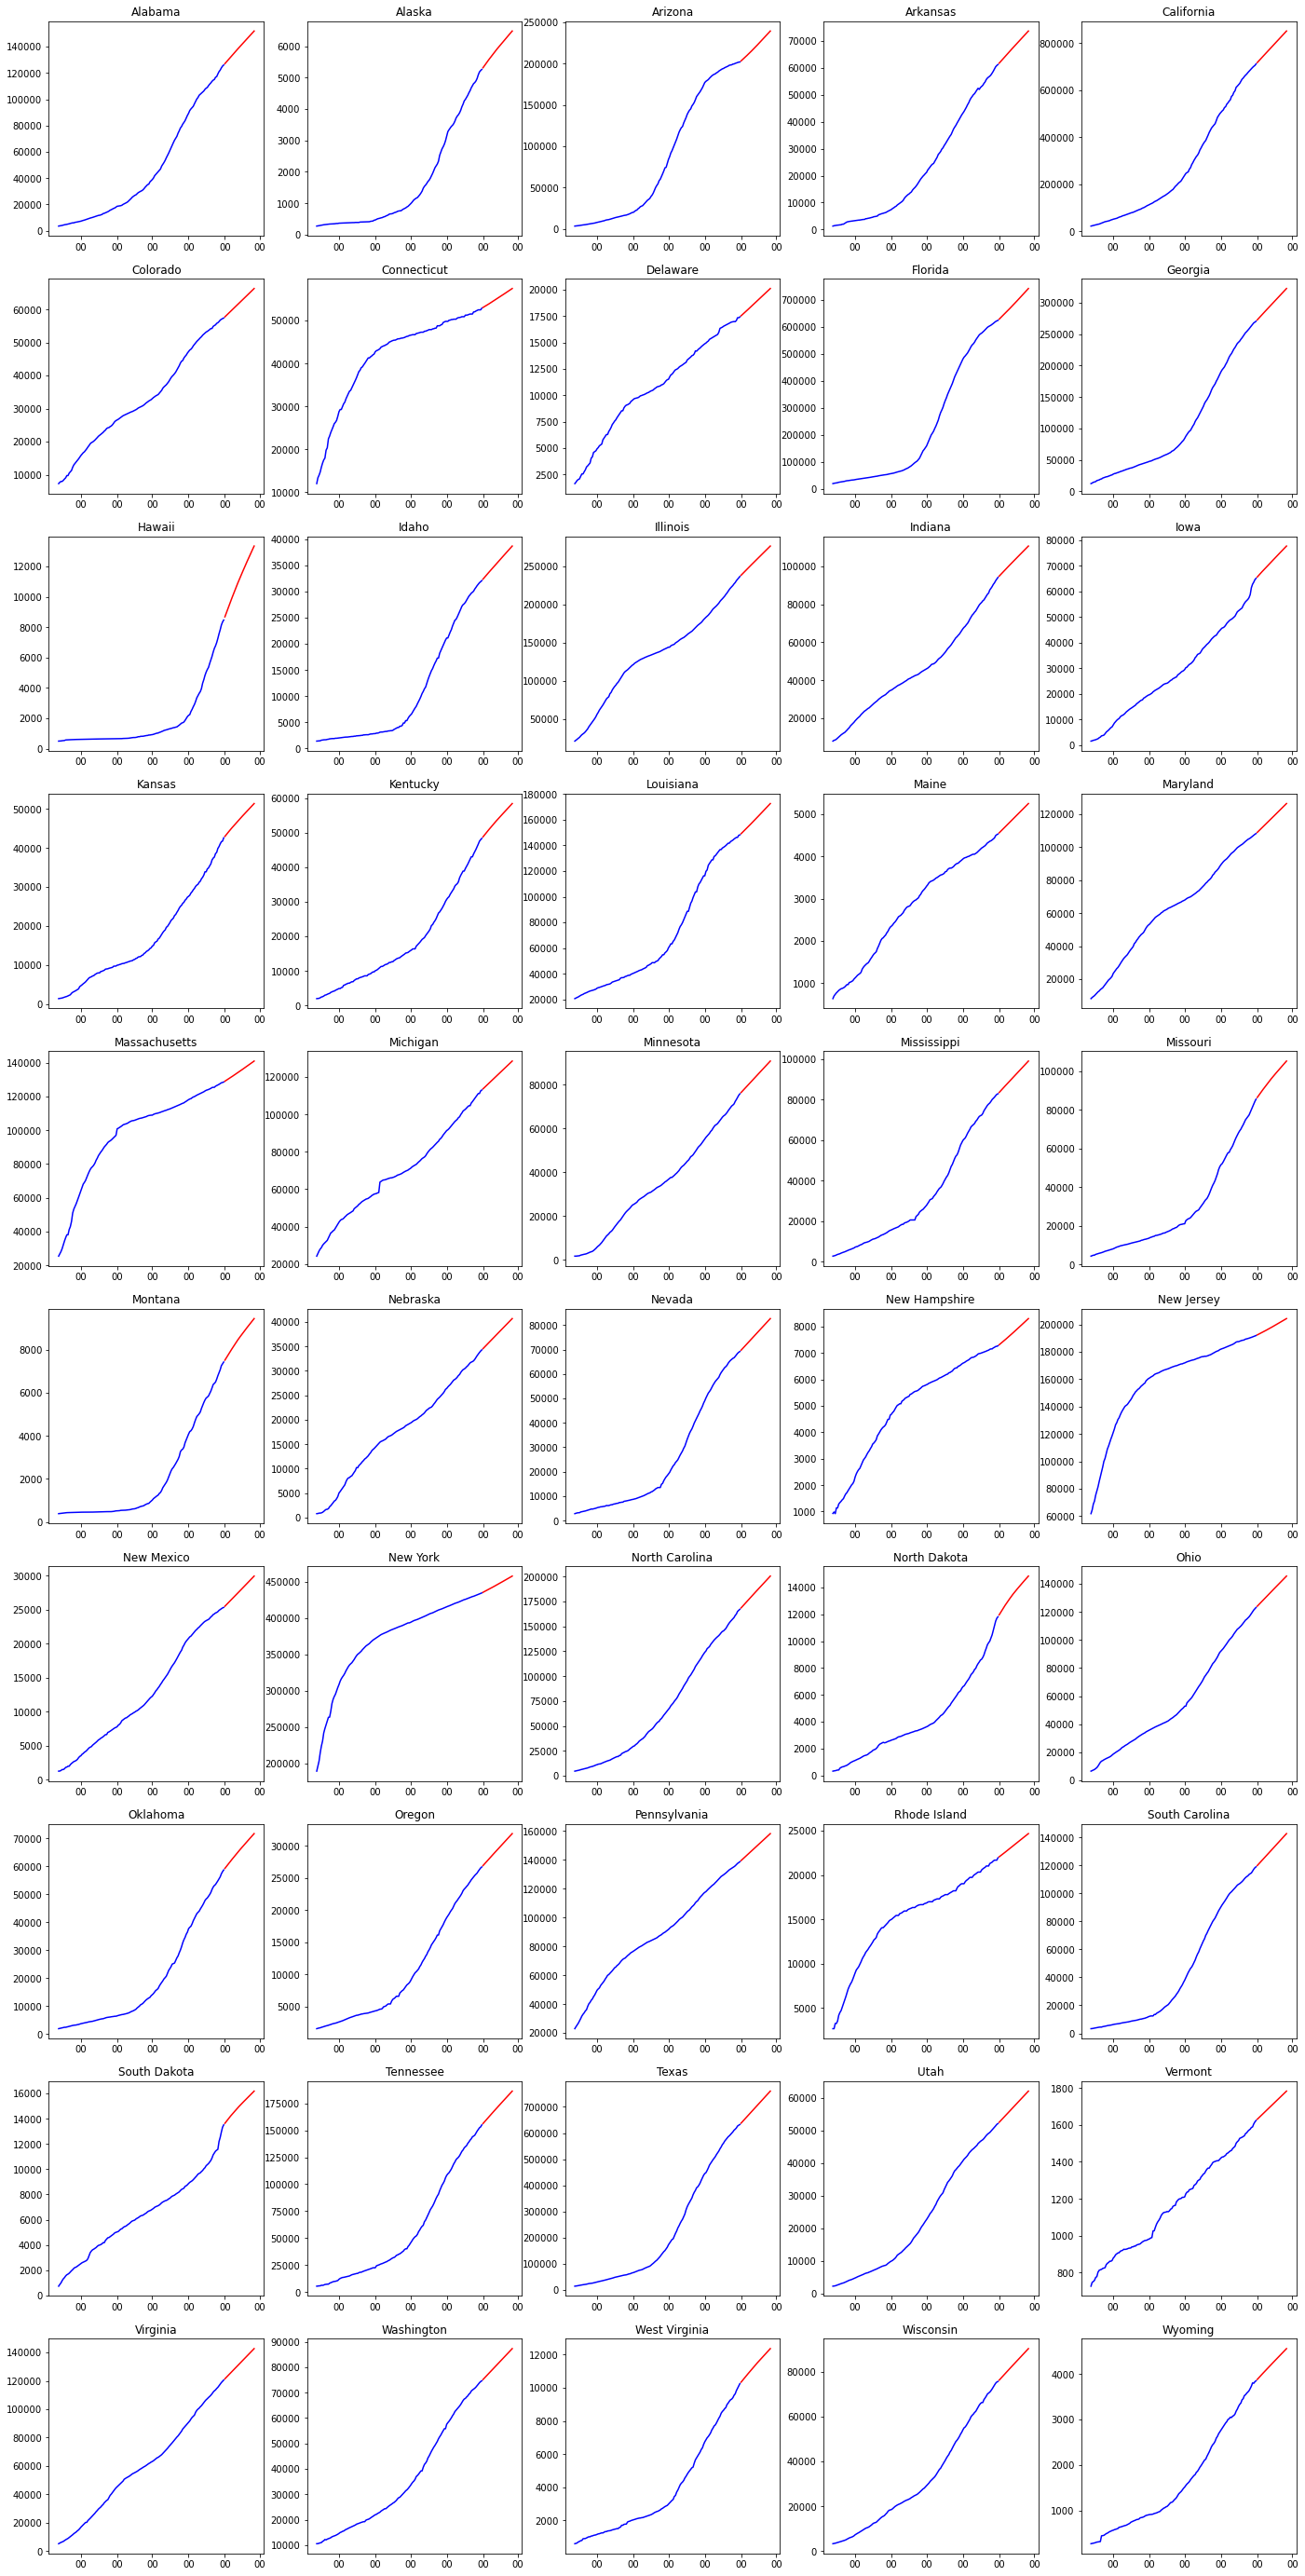

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (24, 50)

fig, ax = plt.subplots(nrows=10, ncols=5)

i = 0
for row in ax:
    for col in row:
        state = states[i]
        i += 1

        data = state_dfs_raw[state]['Confirmed'].copy()
        data.index = state_dfs[state].index
        fc = cleaned_dfs[state]['Confirmed']
        df = pd.DataFrame()
        df['y'] = data
        df = df.merge(fc, how='outer', left_index=True, right_index=True)

        col.set_title(state)
        col.xaxis.set_major_locator(mpl.dates.MonthLocator())
        col.xaxis.set_major_formatter(mpl.dates.DateFormatter('%M'))
        col.plot(df.index, df['y'], color='blue')
        col.plot(df.index, df['Confirmed'], color='red')

plt.show()

In [46]:
kaggle_res

,Confirmed,Deaths
ForecastID,,
0,127080,2197
1,5315,37
2,203108,5066
3,61713,805
4,717959,13115
...,...,...
1295,142715,3013
1296,87281,2150
1297,12360,269


In [47]:
kaggle_res.to_csv('submission.csv')